# Deep Convolutional GANs

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

In [2]:
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets('../MNIST_data', validation_size=0)

Extracting ../MNIST_data/train-images-idx3-ubyte.gz
Extracting ../MNIST_data/train-labels-idx1-ubyte.gz
Extracting ../MNIST_data/t10k-images-idx3-ubyte.gz
Extracting ../MNIST_data/t10k-labels-idx1-ubyte.gz


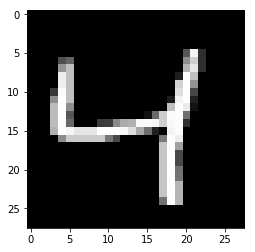

In [3]:
img = mnist.train.images[2]
img = img.reshape((28, 28))
plt.imshow(img, cmap="Greys_r")
plt.show()

### Define handy functions 
Here, I define handy functions to be used to build the generator and the discriminator. 

In [4]:
def leaky_relu(x, alpha=0.2):
    return tf.maximum(x * alpha, x)

def conv2d(x, W_size, name, strides=[1, 1, 1, 1]):
    """
    make conv layer
    
    :param x: input to conv layer. the size must match with W_size. 
    :param W_size: list. [filter_width, filter_height, input_channel, output_channel]
    :param strides: list of strides of each dimension as follows. [batch, width, height, channel] 
    :return: returns conv layer with bias b added. 
    """
    W = tf.get_variable(shape=W_size, name=name+"/weight")
    b = tf.get_variable(shape=W_size[3], name=name+"/bias")
    conv = tf.nn.conv2d(input=x, filter=W, strides=strides, padding="SAME")
    return conv + b

### Define inputs. 
There are two inputs needed; one is real image input for discriminator, and one is random noise input for generator. <br>
Real image input is denoted as x, and random noise is z. 

In [5]:
def initialize_inputs(x_size, z_size):
    """
    initialize inputs x and z. 
    
    x is for real data, and z is for random noise for generator. 
    
    :param z_size: size of z vector
    :return x and z 
    """
    x = tf.placeholder(dtype=tf.float32, shape=[None, *x_size], name="input_real")
    z = tf.placeholder(dtype=tf.float32, shape=[None, z_size], name="input_z")
    
    return x, z

### Generator 
Define a generator. <br>
In the conv layer, I will use image resizing to avoid checker board pattern. <br>
ref: https://distill.pub/2016/deconv-checkerboard/


In [6]:
def generator(z, z_size, reuse=False, training=True):
    """
    :param z: a vector with length z_size, where every elements of z is between -1 and 1
    :param z_size: length of the z vector
    :param reuse: boolean. whether to reuse the trained variable of weights. 
    :param training: boolean. whether it is training or not
    :return: creates generator and return the logits and model
    """
    with tf.variable_scope("generator", reuse=reuse):
        # layer 1: fully connected layer 
        # change the length of z such that it fits to conv layer 
        W_fc1 = tf.get_variable(shape=[z_size, 7*7*128], name="fc_weight")
        b_fc1 = tf.get_variable(shape=7*7*128, name="fc_bias")
        h_fc1 = tf.matmul(z, W_fc1) + b_fc1
        # now, (7*7*128, )

        # layer 2: reshape layer 
        reshape2 = tf.reshape(h_fc1, shape=[-1, 7, 7, 128])
        # now, 7 x 7 x 128
        batch_norm2 = tf.layers.batch_normalization(reshape2, training=training)
        relu2 = leaky_relu(batch_norm2)

        # layer 3: conv layer 
        resize3 = tf.image.resize_nearest_neighbor(images=relu2, size=(14, 14))
        # now, 14 x 14 x 128
        conv3 = conv2d(x=resize3, W_size=[5, 5, 128, 64], name="conv3")
        # now, 14 x 14 x 64
        batch_norm3 = tf.layers.batch_normalization(conv3, training=training)
        relu3 = leaky_relu(batch_norm3)

        # layer 4: conv layer 
        resize4 = tf.image.resize_nearest_neighbor(images=relu3, size=(28, 28))
        # now, 28 x 28 x 64
        conv4 = conv2d(x=resize4, W_size=[5, 5, 64, 32], name="conv4")
        # now, 28 x 28 x 32
        batch_norm4 = tf.layers.batch_normalization(conv4, training=training)
        relu4 = leaky_relu(batch_norm4)
        
        # layer 5: output layer 
        logits = conv2d(x=relu4, W_size=[5, 5, 32, 1], name="output")
        model = tf.tanh(logits)
        
        return logits, model
    

### Discriminator 
Defining discriminator 

In [7]:
def discriminator(x, reuse=False, training=True):
    """
    :param x: list [None, 28, 28, 1], where every element is between -1 and 1
    :param reuse: boolean. whether to reuse the trained variable of weights. 
    :param training: boolean. whether it is training or not
    :return: creates discriminator and returns logits and model 
    """
    with tf.variable_scope("discriminator", reuse=reuse):
        # layer 1: conv layer 
        conv1 = conv2d(x=x, W_size=[5, 5, 1, 64], strides=[1, 2, 2, 1], name="conv1")
        # now, 14 x 14 x 64
        relu1 = leaky_relu(conv1)
        
        # layer 2: conv layer 
        conv2 = conv2d(x=relu1, W_size=[5, 5, 64, 128], strides=[1, 2, 2, 1], name="conv2")
        # now, 7 x 7 x 128
        batch_norm2 = tf.layers.batch_normalization(conv2, training=training)
        relu2 = leaky_relu(batch_norm2)
        
        # layer 3: reshape 
        reshape3 = tf.reshape(relu2, shape=[-1, 7*7*128])
        
        # layer 4: fc layer 
        W_fc4 = tf.get_variable(shape=[7*7*128, 1], name="fc_weight")
        b_fc4 = tf.get_variable(shape=[1], name="fc_bias")
        logits = tf.matmul(reshape3, W_fc4) + b_fc4
        # now, (1, )
        model = tf.nn.sigmoid(logits)
        
        return logits, model

### Loss function 
Define loss function. 

In [8]:
def loss(x, z, z_size):
    """
    define the loss functions of discriminator and generator 
    
    :param x: real image
    :param z: random noize z 
    :param z_size: size of random noise 
    :return: d_loss, g_loss
    """
    # generate fake images 
    g_logits, g_model = generator(z=z, z_size=z_size)
    # using real and fake images, get outputs of discriminator  
    d_real_logits, d_real_model = discriminator(x=x)
    d_fake_logits, d_fake_model = discriminator(x=g_model, reuse=True)
    
    # define discriminator loss
    d_real_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_real_logits, labels=tf.ones_like(d_real_logits)))
    d_fake_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_fake_logits, labels=tf.zeros_like(d_fake_logits)))
    d_loss = d_real_loss + d_fake_loss
    
    # define generator loss
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_fake_logits, labels=tf.ones_like(d_fake_logits)))
    
    return d_loss, g_loss
        

### Optimizer 

In [9]:
def optimizer(d_loss, g_loss, learning_rate, beta1):
    # get variables to update
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
    
    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    return d_train_opt, g_train_opt

### build networks 

In [10]:
tf.reset_default_graph()

# define hyperparameters
z_size = 100
learning_rate = 0.0002
x_size = [28, 28, 1]
beta1 = 0.5

# initializ inputs
x, z = initialize_inputs(x_size=x_size, z_size=z_size)

# define loss function 
d_loss, g_loss = loss(x=x, z=z, z_size=z_size)

# define optimizers 
d_opt, g_opt = optimizer(d_loss, g_loss, learning_rate, beta1)

### Training
the purpose of this DCGAN is to create the generator producing fake hand-written numbers. Thus, we need to save the trained generator weights. 

epoch 0;  1.20458 0.607349
epoch 1;  1.15007 1.21957
epoch 2;  1.06286 0.702389
epoch 3;  1.10885 0.944992
epoch 4;  1.17915 1.15526
epoch 5;  1.08729 1.10156
epoch 6;  1.05339 0.879052
epoch 7;  1.19778 0.593986
epoch 8;  1.17876 0.647315
epoch 9;  1.39427 0.399473


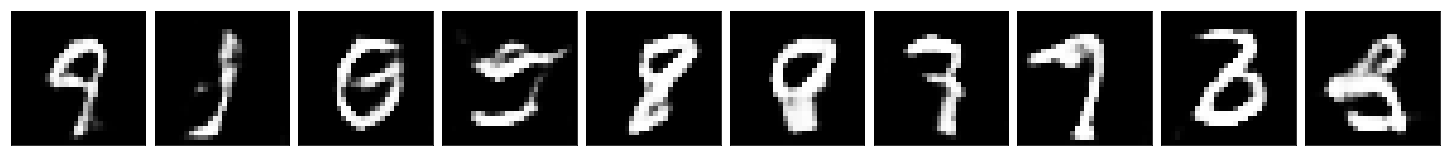

epoch 10;  1.17054 0.644742
epoch 11;  1.13632 1.19214
epoch 12;  1.10521 1.12548
epoch 13;  1.02898 1.00383
epoch 14;  1.10571 1.0999
epoch 15;  1.05144 1.13445
epoch 16;  1.14928 0.997319
epoch 17;  1.17365 0.663492
epoch 18;  1.14474 0.811808
epoch 19;  1.12458 0.959374


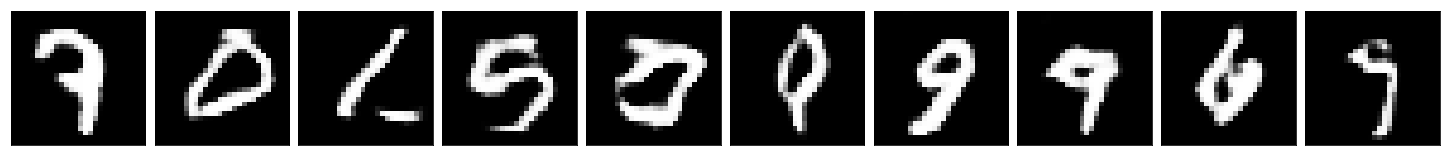

epoch 20;  1.13638 1.26758
epoch 21;  1.27327 0.673405
epoch 22;  1.11678 1.22683
epoch 23;  1.1465 0.810016
epoch 24;  1.13391 1.22152
epoch 25;  1.10905 1.11151
epoch 26;  1.08219 0.980963
epoch 27;  1.15764 0.746789
epoch 28;  1.13983 0.975372
epoch 29;  1.12254 0.943845


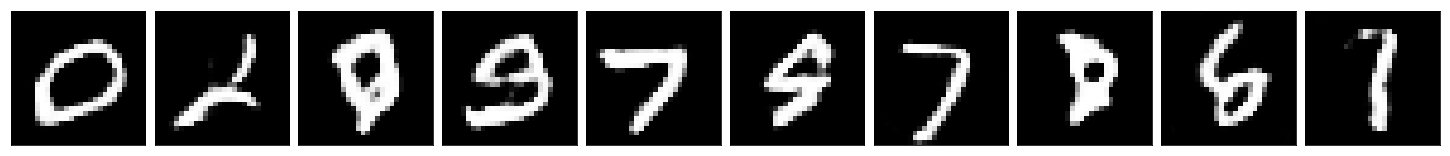

epoch 30;  0.991738 0.972693
epoch 31;  1.19006 0.817327
epoch 32;  1.11644 0.853417
epoch 33;  1.13161 1.0763
epoch 34;  1.16512 0.846889
epoch 35;  1.09539 0.88769
epoch 36;  1.15582 0.972419
epoch 37;  1.09376 0.968242
epoch 38;  1.09277 0.976407
epoch 39;  1.09459 1.04747


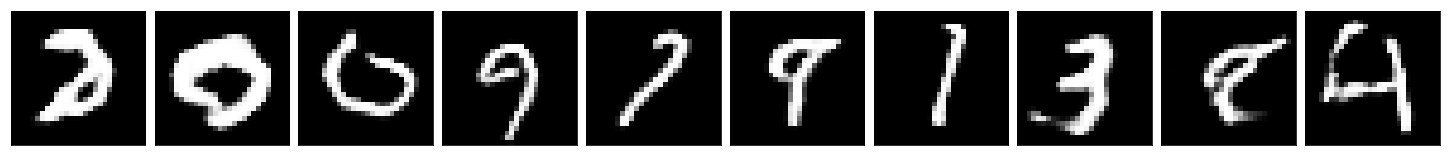

epoch 40;  1.10551 1.02796
epoch 41;  1.20793 0.986229
epoch 42;  1.18793 0.86254
epoch 43;  1.14802 0.830548
epoch 44;  1.04511 0.873583
epoch 45;  1.18653 0.710929
epoch 46;  1.17737 0.706653
epoch 47;  1.21826 0.982597
epoch 48;  1.17695 0.777207
epoch 49;  1.15416 1.09466


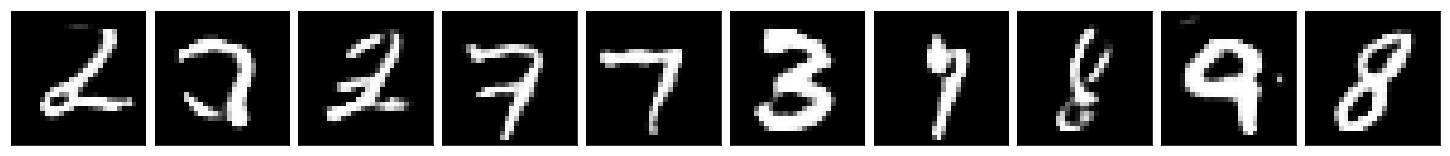

epoch 50;  1.13297 0.891432
epoch 51;  1.23249 1.09177
epoch 52;  1.17469 0.777836
epoch 53;  1.16155 0.822608
epoch 54;  1.1108 0.784642
epoch 55;  1.17215 0.673868
epoch 56;  1.13518 0.927666
epoch 57;  1.17808 0.778285
epoch 58;  1.1463 0.817783
epoch 59;  1.1577 0.864079


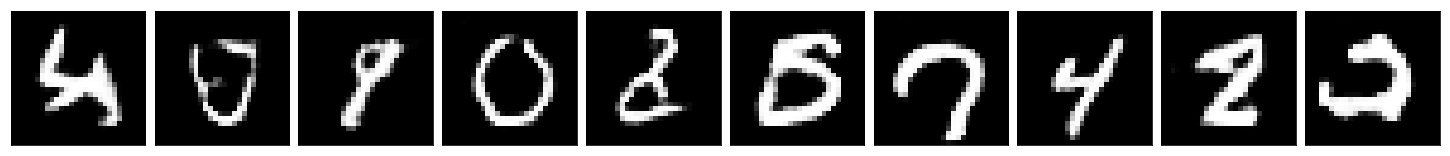

epoch 60;  1.16859 0.993383
epoch 61;  1.18956 1.37581
epoch 62;  1.14499 0.918053
epoch 63;  1.03811 1.0408
epoch 64;  1.08456 1.1403
epoch 65;  1.15643 0.885428
epoch 66;  1.2438 0.78704
epoch 67;  1.14771 1.03734
epoch 68;  1.12332 0.924299
epoch 69;  1.11529 0.874357


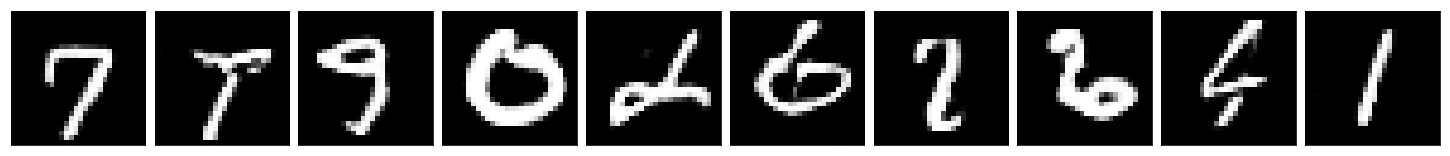

epoch 70;  1.06203 0.840023
epoch 71;  1.13623 0.937936
epoch 72;  1.14253 1.01214
epoch 73;  1.12156 0.938881
epoch 74;  1.15364 0.977268
epoch 75;  1.15976 1.08644
epoch 76;  1.21902 1.11296
epoch 77;  1.10203 1.04339
epoch 78;  1.11141 0.899386
epoch 79;  1.22792 0.757995


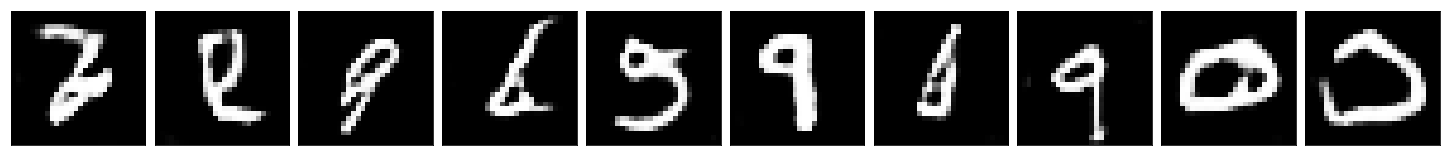

epoch 80;  1.12099 1.03647
epoch 81;  1.20892 1.12083
epoch 82;  1.16023 0.944408
epoch 83;  1.21235 0.720372
epoch 84;  1.21291 0.734268
epoch 85;  1.16756 0.711124
epoch 86;  1.12333 0.887307
epoch 87;  1.12061 1.03325
epoch 88;  1.17147 0.923258
epoch 89;  1.12381 0.972111


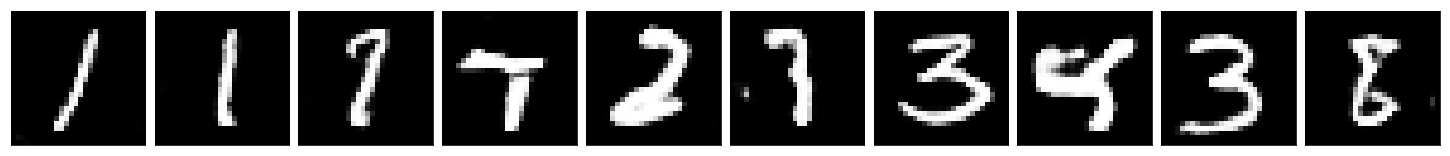

epoch 90;  1.14732 0.970861
epoch 91;  1.19269 0.80077
epoch 92;  1.20381 1.0295
epoch 93;  1.11241 0.999179
epoch 94;  1.15245 0.769344
epoch 95;  1.19604 0.835106
epoch 96;  1.16345 1.38173
epoch 97;  1.15851 0.83668
epoch 98;  1.14018 0.977938
epoch 99;  1.15602 0.983614


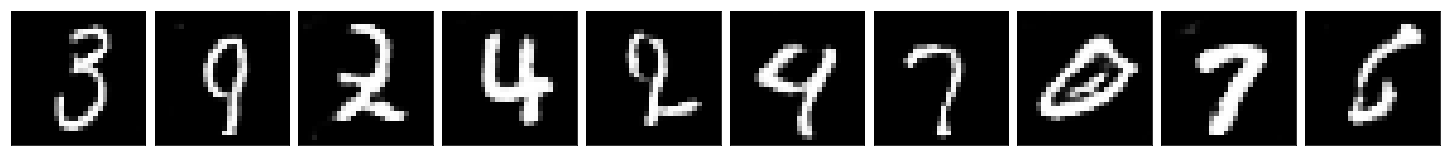

In [11]:
epochs = 100
batch_size = 100
saver = tf.train.Saver()
sample_size = 10

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    for e in range(epochs):
        for i in range(batch_size):
            # get imgs, reshape and rescale to pass to discriminator
            batch = mnist.train.next_batch(batch_size)
            real_imgs = batch[0].reshape(-1, 28, 28, 1)
            real_imgs = real_imgs*2 - 1

            # generate random vector for z 
            rand_noise = np.random.uniform(-1, 1, size=(batch_size, z_size))
            
            # update discriminator and generator 
            sess.run(g_opt, feed_dict={x:real_imgs, z:rand_noise})
            sess.run(d_opt, feed_dict={x:real_imgs, z:rand_noise})
            
        # print training losses 
        train_loss_d = d_loss.eval({x:real_imgs, z:rand_noise})
        train_loss_g = g_loss.eval({z:rand_noise})
        print("epoch " + str(e) + "; ", train_loss_d, train_loss_g)
        
        # print generated images 
        if (e+1)%10 == 0:
            # generate fake images
            sample_z = np.random.uniform(-1, 1, size=(sample_size, z_size))
            g_logits, g_imgs = sess.run(generator(z, z_size, reuse=True), feed_dict={z: sample_z})
            
            # plot fake images 
            fig, axes = plt.subplots(1, 10, figsize=(20, 2))
            for index, ax in enumerate(axes):
                ax.imshow(g_imgs[index][:, :, 0], cmap='Greys_r')
                ax.get_xaxis().set_visible(False)
                ax.get_yaxis().set_visible(False)
            fig.tight_layout(pad=0.2)
            plt.show()
    
    # save the trained generator weights
    saver.save(sess, './checkpoints/generator.ckpt')
        
    